# _POS tagging with modified techniques on Vanilla Viterbi_

In [71]:
#Importing necessary libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [72]:
# reading the Treebank dataset with universal tags
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [73]:
# printing the no of tagged words
tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

In [74]:
# printing the no of coarse tag classes
tags =  [t[1] for t in tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [75]:
#finding the most frequet tag in the corpus
from collections import Counter
tag_counts = Counter(tags)
tag_counts.most_common()

[('NOUN', 28867),
 ('VERB', 13564),
 ('.', 11715),
 ('ADP', 9857),
 ('DET', 8725),
 ('X', 6613),
 ('ADJ', 6397),
 ('NUM', 3546),
 ('PRT', 3219),
 ('ADV', 3171),
 ('PRON', 2737),
 ('CONJ', 2265)]

## Splitting the dataset into train data and test data

In [76]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, train_size=0.95)

print("Train dataset size -", len(train_set))
print("Test dataset size -", len(test_set))

Train dataset size - 3718
Test dataset size - 196


In [77]:
# retrieving list of tagged words for train dataset

train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95432

In [78]:
# Tagged words in the training set

train_tagged_words[:10]

[('Your', 'PRON'),
 ('$', '.'),
 ('15,000', 'NUM'),
 ('*U*', 'X'),
 ('will', 'VERB'),
 ('help', 'VERB'),
 ('*-1', 'X'),
 ('keep', 'VERB'),
 ('a', 'DET'),
 ('needy', 'ADJ')]

In [79]:
# tokens in the train set - train_tagged_words

train_data_tokens = [pair[0] for pair in train_tagged_words]
train_data_tokens[:10]

['Your', '$', '15,000', '*U*', 'will', 'help', '*-1', 'keep', 'a', 'needy']

In [80]:
# POS tags for the tokens in the train set -

train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['PRON', '.', 'NUM', 'X', 'VERB', 'VERB', 'X', 'VERB', 'DET', 'ADJ']

In [84]:
# build the train vocabulary to a set

train_vocabulary_set = set(train_data_tokens)

In [85]:
# build the POS tags to a set

train_pos_tag_set = set(train_data_pos_tags)

In [86]:
print("Length : \nVocabulary: {} \nTags: {}".format(len(train_vocabulary_set), len(train_pos_tag_set)))
print("\nAvailable Tags :\n")
print(train_pos_tag_set)

Length : 
Vocabulary: 12011 
Tags: 12

Available Tags :

{'DET', 'ADV', 'NOUN', 'PRON', 'ADJ', '.', 'X', 'CONJ', 'NUM', 'PRT', 'VERB', 'ADP'}


In [87]:
# computing P(w/t) and storing in [Tags x Vocabulary] matrix. 
len_pos_tags = len(train_pos_tag_set)
len_vocab = len(train_vocabulary_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [88]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [89]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [90]:
# creating t x t transition matrix of tags

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]



In [91]:
tags_matrix

array([[5.31016150e-03, 1.25512909e-02, 6.37702167e-01, 3.62056470e-03,
        2.05889449e-01, 1.76200829e-02, 4.53777462e-02, 4.82741976e-04,
        2.26888731e-02, 1.20685494e-04, 3.93434726e-02, 9.29278322e-03],
       [6.81667775e-02, 8.00794140e-02, 3.24288532e-02, 1.55526139e-02,
        1.28060892e-01, 1.37326270e-01, 2.25016549e-02, 6.94904057e-03,
        2.97816023e-02, 1.45598939e-02, 3.45466584e-01, 1.19126409e-01],
       [1.34269930e-02, 1.69758163e-02, 2.63381273e-01, 4.64639813e-03,
        1.20367324e-02, 2.38978520e-01, 2.90857200e-02, 4.26224694e-02,
        9.47572570e-03, 4.41224910e-02, 1.47440821e-01, 1.77807048e-01],
       [9.61908419e-03, 3.34744118e-02, 2.08926514e-01, 8.08003079e-03,
        7.11812228e-02, 4.04001549e-02, 9.27279741e-02, 5.38668735e-03,
        6.92574074e-03, 1.23124281e-02, 4.87495184e-01, 2.34705657e-02],
       [4.62351367e-03, 4.45838831e-03, 6.98645949e-01, 6.60502003e-04,
        6.60502017e-02, 6.48943186e-02, 2.17965655e-02, 1.70

In [92]:
# matrix to a data frame for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))


In [93]:
# dataset
tags_df

,DET,ADV,NOUN,PRON,ADJ,.,X,CONJ,NUM,PRT,VERB,ADP
DET,0.005310,0.012551,0.637702,0.003621,0.205889,0.017620,0.045378,0.000483,0.022689,0.000121,0.039343,0.009293
ADV,0.068167,0.080079,0.032429,0.015553,0.128061,0.137326,0.022502,0.006949,0.029782,0.014560,0.345467,0.119126
NOUN,0.013427,0.016976,0.263381,0.004646,0.012037,0.238979,0.029086,0.042622,0.009476,0.044122,0.147441,0.177807
PRON,0.009619,0.033474,0.208927,0.008080,0.071181,0.040400,0.092728,0.005387,0.006926,0.012312,0.487495,0.023471
ADJ,0.004624,0.004458,0.698646,0.000661,0.066050,0.064894,0.021797,0.017008,0.020806,0.010568,0.011724,0.078765
.,0.173480,0.052732,0.221056,0.066299,0.044863,0.093433,0.027587,0.058520,0.080590,0.002261,0.088911,0.090177
X,0.054166,0.026605,0.062610,0.055281,0.017206,0.163295,0.074558,0.009559,0.002549,0.184961,0.204078,0.145133
CONJ,0.118360,0.056384,0.352749,0.058248,0.115098,0.035415,0.007456,0.000466,0.042404,0.005126,0.156104,0.052190
NUM,0.003281,0.002982,0.356397,0.000895,0.033403,0.115419,0.208470,0.014017,0.184313,0.026842,0.017894,0.036087
PRT,0.100164,0.009820,0.249100,0.018003,0.083797,0.041899,0.013421,0.002291,0.056301,0.001637,0.403273,0.020295


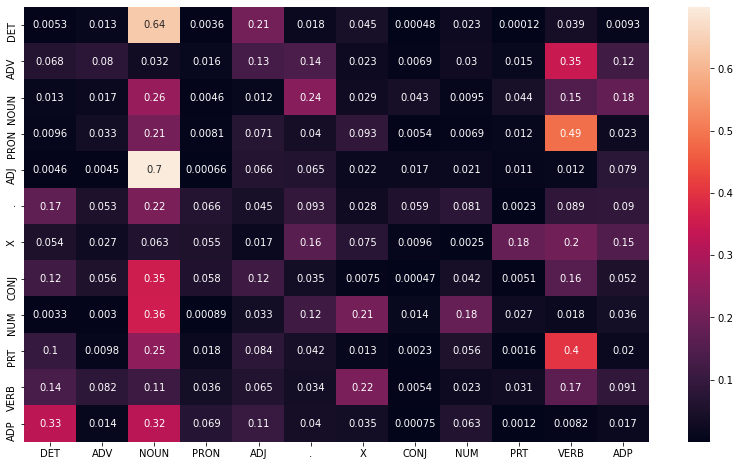

In [94]:
# heatmap of tags matrix
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

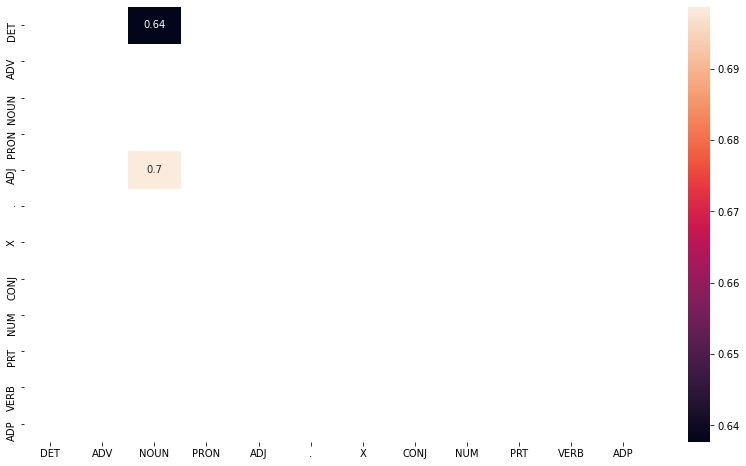

In [95]:
# frequent tags
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

### Vanilla Viterbi based POS tagger

In [36]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
      
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
           
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
      
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [96]:
# Running the Viterbi algorithm on a few sample sentences as it takes time to run entire data set

random.seed(1234)

# choose random 5 sents
rnd = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rnd]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

tagged_seq = Vanilla_Viterbi(test_tagged_words)

In [97]:
# Accuracy of the vanilla viterbi algorithm

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("Accuracy of Vanilla Viterbi Algorithm: -", vanilla_viterbi_accuracy)

Accuracy of Vanilla Viterbi Algorithm: - 0.8802395209580839


In [98]:
# Incorrect tagged cases

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

20


[[('In', 'ADP'), (('1973', 'DET'), ('1973', 'NUM'))],
 [(',', '.'), (('Wells', 'DET'), ('Wells', 'NOUN'))],
 [('Wells', 'NOUN'), (('Fargo', 'DET'), ('Fargo', 'NOUN'))],
 [('which', 'DET'), (('*T*-198', 'DET'), ('*T*-198', 'X'))],
 [('free', 'ADJ'), (('checking', 'VERB'), ('checking', 'NOUN'))],
 [(',', '.'), (('safe-deposit', 'DET'), ('safe-deposit', 'ADJ'))],
 [('and', 'CONJ'), (('travelers', 'DET'), ('travelers', 'NOUN'))],
 [('to', 'PRT'), (('speak', 'DET'), ('speak', 'VERB'))],
 [('at', 'ADP'), (('theological', 'DET'), ('theological', 'ADJ'))],
 [('theological', 'ADJ'), (('colleges', 'DET'), ('colleges', 'NOUN'))],
 [('the', 'DET'), (('joys', 'DET'), ('joys', 'NOUN'))],
 [('bell', 'NOUN'), (('ringing', 'VERB'), ('ringing', 'NOUN'))],
 [('a', 'DET'), (('booklet', 'DET'), ('booklet', 'NOUN'))],
 [('country', 'NOUN'), (('entitled', 'DET'), ('entitled', 'VERB'))],
 [('The', 'DET'), (('Bells', 'DET'), ('Bells', 'NOUN'))],
 [('and', 'CONJ'), (('clothing', 'DET'), ('clothing', 'NOUN'))],


### Solve the problem of unknown words

#### Unknown words are new to training data which are present only in test data and which were not included while running the alogrithm on train set. When the algorithm hits an unknown word, it naively assigns the first tag in the list of tags that we have created making it less accurate.

In [42]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - train_vocabulary_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 5


Unknown Words : ['sticker', 'index-related', 'hauling', 'tightened', 'cushion']


# Technique 1

### If word in unknown then consider only the transition_p as emission probability will be ZERO else consider both the emission and transition probability.

In [99]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            if word not in train_vocabulary_set:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability) 
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [101]:
# Tag test sentences
tagged_seq_unknown = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
check_unknown = [i for i, j in zip(tagged_seq_unknown, test_run_base) if i == j]
optimized_viterbi_accuracy = len(check_unknown)/len(tagged_seq_unknown)

print("Accuracy of the Vanilla Viterbi Algorithm after handling unknown words: -", optimized_viterbi_accuracy)

Accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words: - 0.9401197604790419


### We can see an improvement in the accuracy after handling unknown words tagging

## Unigram tagger

In [45]:
# Unigram Tagger

unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", unigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.8935222672064778


## Bigram tagger

In [102]:
# Bigram Tagger

bigram_tagger = nltk.BigramTagger(train_set)
bigram_tagger_accuracy = bigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", bigram_tagger_accuracy)

The accuracy of the Unigram Tagger is - 0.17734553775743708


## Unigram tagger with backoff as rule_based_tagger

In [103]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              
    (r'.*s$', 'NOUN'),                
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'),
    (r'.*ould$', 'X'), 
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), 
    (r'[0-9].?[,\/]?[0-9]*','NUM')
    ]

In [104]:
# RegexpTagger

rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("Accuracy of the Unigram Tagger backed up by the RegexpTagger:-", accuracy_rule_based_unigram_tagger)

Accuracy of the Unigram Tagger backed up by the RegexpTagger:- 0.9282990083905416


## Bigram tagger with backoff as rule_based_unigram_tagger

In [111]:
# Bigram tagger with backoff as rule_based_unigram_tagger

rule_based_bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
rule_based_bigram_tagger.evaluate(test_set)
accuracy_rule_based_bigram_tagger = rule_based_bigram_tagger.evaluate(test_set)
print("Accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger:-", accuracy_rule_based_bigram_tagger)

Accuracy of the Bigram Tagger backed up by the rule_based_unigram_tagger:- 0.9305873379099924


## Trigram tagger with backoff as  rule_based_bigram_tagger

In [131]:
# trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = rule_based_bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("Accuracy of the Trigram Tagger backed up by the bigram_tagger is:-", accuracy_trigram_tagger)

Accuracy of the Trigram Tagger backed up by the bigram_tagger is:- 0.9302059496567505


## Bigram tagger with backoff as regex_based_tagger i.e the rule based tagger

In [107]:
# trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), 
    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),             
    (r'.*s$', 'NOUN'),               
    (r'.*ers$', 'NOUN'),             
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), 
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), 
    (r'[0-9].?[,\/]?[0-9]*','NUM'),
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)
    # Regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

# Technique 2

## Viterbi with backoff as trigram_tagger

In [108]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in train_vocabulary_set:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
   
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [109]:
# Tag test sentences
viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(test_tagged_words)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_run_base) if i == j]
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(viterbi_trigram_tagged_seq)

print("Accuracy of the viterbi_backedup_by_trigram_tagger:-", viterbi_trigram_accuracy)

Accuracy of the viterbi_backedup_by_trigram_tagger:- 0.9580838323353293


#### Evaluating tagging accuracy

In [112]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy*100], 
                  ['Optimized Vanilla Viterbi', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Bigram Tagger', bigram_tagger_accuracy*100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_rule_based_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])
acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)
acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,88.023952
Optimized Vanilla Viterbi,94.011976
Unigram Tagger,89.352227
Bigram Tagger,17.734554
Unigram + RegexpTagger,92.829901
Bigram Tagger + Unigram_tagger,93.058734
Trigram Tagger + Bigram_tagger,93.020595
Viterbi + Trigram_tagger,95.808383


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

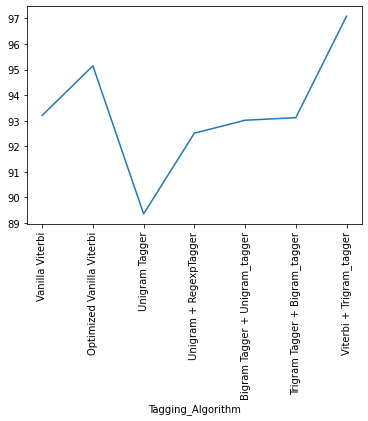

In [57]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

# Validating on sample test sentences provided

In [113]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [114]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [115]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

In [116]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### 1. Testing the accuracy of Vanilla Viterbi on Sample test data

In [117]:
# tag test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]
vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)
print("Accuracy of the Vanilla Viterbi Algorithm on the Sample test data:-", vanilla_viterbi_accuracy_on_sample_test_data)

Accuracy of the Vanilla Viterbi Algorithm on the sample test data:- 0.7513812154696132


### 2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on Sample test data

In [118]:
# tag the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]
sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("Accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data:-", sample_test_optimized_viterbi_accuracy)

Accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data:- 0.861878453038674


### 3. Testing the accuracy of viterbi_backedup_by_trigram_tagger on Sample test data 

In [119]:
# tag  test sentences
sample_test_viterbi_trigram_tagged_seq = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


## Apparently Viterbi backed up by trigram_tagger perfomed well with higher accuracy followed by Viterbi that handled unknown words

In [129]:
# test sentences to list down all the words that were properly tagged after modifications

sample_sentence_1 = 'Android is a mobile operating system developed by Google.'
sample_sentence_2 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
sample_sentence_3 = "Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco."


## Case1

In [124]:

words_sample_sentence_1 = nltk.word_tokenize(sample_sentence_1)

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi1 = Vanilla_Viterbi(words_sample_sentence_1)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi1)

print('\n')

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_unknown1 = Vanilla_Viterbi_for_Unknown_Words(words_sample_sentence_1)
print("Tagging sequence with Vanilla_Viterbi after handling unknown words -\n\n", pos_tagged_sequence_with_vanilla_viterbi_unknown1)

print('\n')

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram1 = viterbi_backedup_by_trigram_tagger(words_sample_sentence_1)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram1)

Tagging sequence with Vanilla_Viterbi -

 [('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]


Tagging sequence with Vanilla_Viterbi after handling unknown words -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]


Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


> **Android** and **Google** are unknown words which were tagged as first tag i.e. **DET** by Vanilla Viterbi arbitrarily<br>
> **Android** is correctly tagged as Noun after handling uknown words in Vanilla Viterbi but **Google** is still wrongly tagged as DET<br>
> Both **Android** and **Google** are correctly tagged as **NOUN** by Vanilla Viterbi backed off by Trigram Tagger <br>

## Case 2

In [128]:

words_sample_sentence_2 = nltk.word_tokenize(sample_sentence_2)

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi2 = Vanilla_Viterbi(words_sample_sentence_2)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi2)

print('\n')

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_unknown2 = Vanilla_Viterbi_for_Unknown_Words(words_sample_sentence_2)
print("Tagging sequence with Vanilla_Viterbi after handling unknown words -\n\n", pos_tagged_sequence_with_vanilla_viterbi_unknown2)

print('\n')

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram2 = viterbi_backedup_by_trigram_tagger(words_sample_sentence_2)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram2)

Tagging sequence with Vanilla_Viterbi -

 [('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'DET'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


Tagging sequence with Vanilla_Viterbi after handling unknown words -

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('on

> **Twitter**, **online** and **tweets** are unknown words which were tagged as first tag i.e. **DET** by Vanilla Viterbi arbitrarily<br>
> **Twitter** and **online** are correctly tagged as Noun after handling unknown words in Vanilla Viterbi but **tweets** is still wrongly tagged as DET<br>
> **Twitter**, **online** and **tweets** are correctly tagged as Noun by Vanilla Viterbi backed off by Trigram Tagger and there is still some inaccuracy while tagging words like **interact** and **messages**<br>

## Case 3

In [130]:

words_sample_sentence_3 = nltk.word_tokenize(sample_sentence_3)

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi3 = Vanilla_Viterbi(words_sample_sentence_3)
print("Tagging sequence with Vanilla_Viterbi -\n\n", pos_tagged_sequence_with_vanilla_viterbi3)

print('\n')

# pos tagging with Vanilla_Viterbi
pos_tagged_sequence_with_vanilla_viterbi_unknown3 = Vanilla_Viterbi_for_Unknown_Words(words_sample_sentence_3)
print("Tagging sequence with Vanilla_Viterbi after handling unknown words -\n\n", pos_tagged_sequence_with_vanilla_viterbi_unknown3)

print('\n')

# pos tags with viterbi_backedup_by_trigram_tagger
pos_tagged_sequence_with_viterbi_trigram3 = viterbi_backedup_by_trigram_tagger(words_sample_sentence_3)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger -\n\n", pos_tagged_sequence_with_viterbi_trigram3)

Tagging sequence with Vanilla_Viterbi -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'DET'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


Tagging sequence with Vanilla_Viterbi after handling unknown words -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('flights', 'NOUN'), ('leaving', 'VERB'), ('Atlanta', 'NOUN'), ('at', 'ADP'), ('about', 'ADP'), ('3', 'NUM'), ('in', 'ADP'), ('the', 'DET'), ('afternoon', 'NOUN'), ('and', 'CONJ'), ('arriving', 'NOUN'), ('in', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('.', '.')]


Tagging sequence with viterbi_backedup_by_trigram_tagger -

 [('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('price', 'NOUN'), ('of', 'ADP

> All the three models performed well on this sample sentence except on the word **arriving** which was arbitrarily tagged as **DET** by Vanilla Viterbi, and wrongly tagged as **NOUN** by Vanilla viterbi after hanlding unknown words and correctly tagged as **VERB** by Vanilla Viterby backed off with trigram tagger

# Summary:
* `Seemingly Viterbi backed off by Trigram Tagger which itself is backed off by rule based bigram tagger performed better with around 95 % accuracy`